# Data visualisation

L'objectif de ce TP est d'explorer et visualiser les données à l'aide de méthodes de réduction dimensionnelle telles que l'ACP (méthode de réduction linéaire) et t-SNE (méthode de réduction non-linéaire).

## Starter: athlete's dataset

In [144]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE as tsne
import scipy.io as sio

In [107]:
dataset = "ais.csv"
df = pd.read_csv(dataset, delimiter=";")

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   athlete  202 non-null    int64  
 1   rcc      202 non-null    float64
 2   wcc      202 non-null    float64
 3   hc       202 non-null    float64
 4   hg       202 non-null    float64
 5   ferr     202 non-null    int64  
 6   bmi      202 non-null    float64
 7   ssf      202 non-null    float64
 8   pcBfat   202 non-null    float64
 9   lbm      202 non-null    float64
 10  ht       202 non-null    float64
 11  wt       202 non-null    float64
 12  sex      202 non-null    object 
 13  sport    202 non-null    object 
dtypes: float64(10), int64(2), object(2)
memory usage: 22.2+ KB


Il y a 202 samples et 13 features

In [74]:
unique, counts = np.unique(df["sport"], return_counts=True)
for u, c in zip(unique, counts):
    print(f"{c} pratiquants de {u}")

25 pratiquants de B_Ball
19 pratiquants de Field
4 pratiquants de Gym
23 pratiquants de Netball
37 pratiquants de Row
22 pratiquants de Swim
29 pratiquants de T_400m
15 pratiquants de T_Sprnt
11 pratiquants de Tennis
17 pratiquants de W_Polo


In [75]:
drop_var = ["athlete", "sport"]
df = pd.DataFrame(df.drop(drop_var, axis=1))

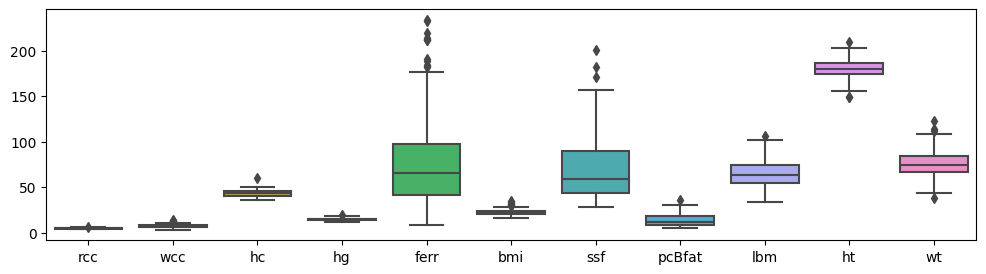

In [76]:
plt.figure(figsize=(12,3))
variables = []
for var in df.columns:
    variables.append(var)
variables.remove("sex")
sns.boxplot(data=df[variables], orient="v")
plt.show()

On observe que certains boxplot sont illisibles, cela est dû à des grands écarts d'échelles au niveau des valeurs, comme on peut le voir dans les premières lignes du DataFrame.  Donc il est nécessaire de normaliser les données. De toute manière, il est nécessaire d'exclure les variables non-numériques pour la matrice de corrélation ensuite.

In [102]:
scaler = StandardScaler(with_mean=True, with_std=True)
df_numeric = df[variables]
X_norm = scaler.fit_transform(df_numeric)
df = pd.DataFrame(X_norm, columns = variables)

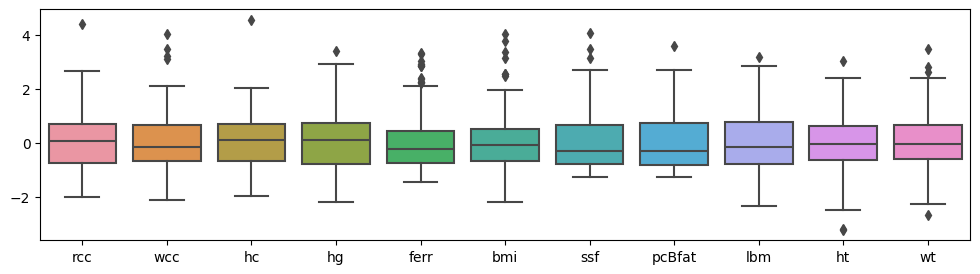

In [84]:
plt.figure(figsize=(12,3))
sns.boxplot(data=df, orient="v")
plt.show()

Toutes les moyennes sont à 0 après normalisation. On observe plusieurs valeurs extrêmes pour *wcc*, *ferr*, *bmi* et *sff* (de nombreux points sont isolés et s'étendent largement au-délà de Q3+1.5*IQR.

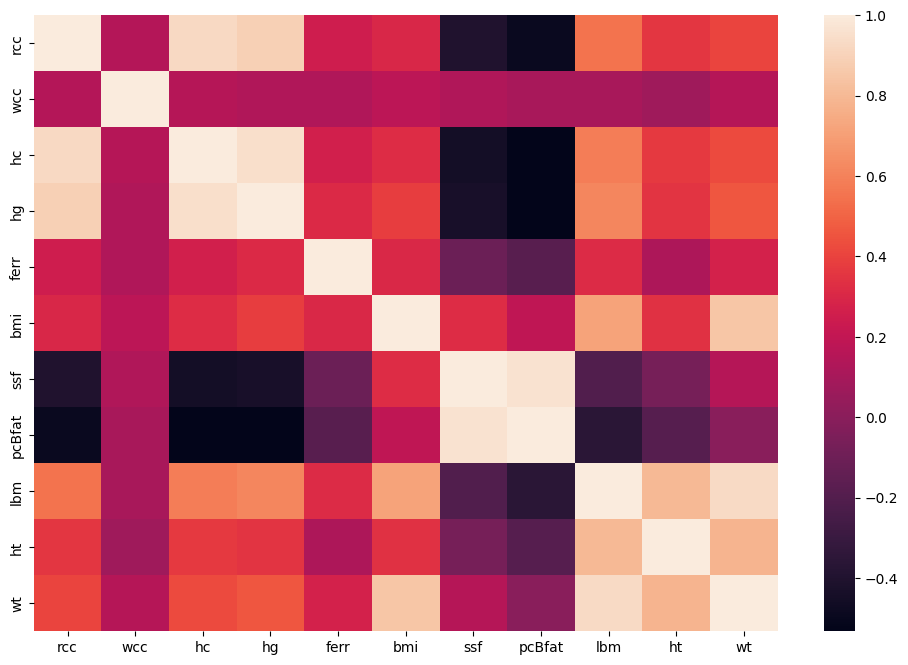

In [85]:
plt.figure(figsize=(12,8))
X_corr = df.corr()
sns.heatmap(X_corr);

Certains features sont très corrélées positivement, par exemple *hg* et *hc* ou *lmb* et *wt*. D'autres sont très corrélées négativement, comme *pcBfat* et *hg*, ou *hg* et *ssf*.

On prend pour label le genre de l'athlète.

In [88]:
Y = df["sex"].values

### PCA

L'objectif de PCA est de réduire la dimensionnalité tout en conservant le plus de variance possible:
1) Calcule les composantes principales: directions orthogonales qui maximise la variance
2) Projette les données sur ces axes

La variance d'une variable indique à quel point elle change, si un feature a peu de variance, c'est qu'elle apporte peu d'information donc elle n'est pas vraiment utile. Lorsqu'on réduit la dimension, on veut conserver l'information essentielle, pas le bruit, ce sont donc les axes avec le plus de variance qui contiennent les features les plus importantes.

In [90]:
pca = PCA()
pca.fit(X_norm)

PCA()

In [91]:
## trace du spectre des valeurs propres et de la variance expliquée
def plot_spectre_variance_expl(valprop):
    tot = sum(np.abs(valprop))
    var_exp = [(i / tot) for i in sorted(np.abs(valprop), reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, valprop.size + 1), np.abs(valprop), alpha=0.5, align="center", label="Individual")
    plt.title("Correlation matrix Eigenvalues")
    plt.ylabel("Explained variance")
    plt.xlabel("Principal components")
    plt.subplot(1, 2, 2)
    markerline, stemlines, baseline = plt.stem(range(1, valprop.size + 1), cum_var_exp, "-r", label="Individual")
    plt.setp(stemlines, "color", "r", "linewidth", 2)
    plt.plot(range(1, valprop.size + 1), cum_var_exp, "b-.",label="Cumulative")
    plt.title("Cumulated explained variance (in %)")
    plt.ylabel("Explained variance")
    plt.xlabel("Principal components")
    plt.tight_layout()

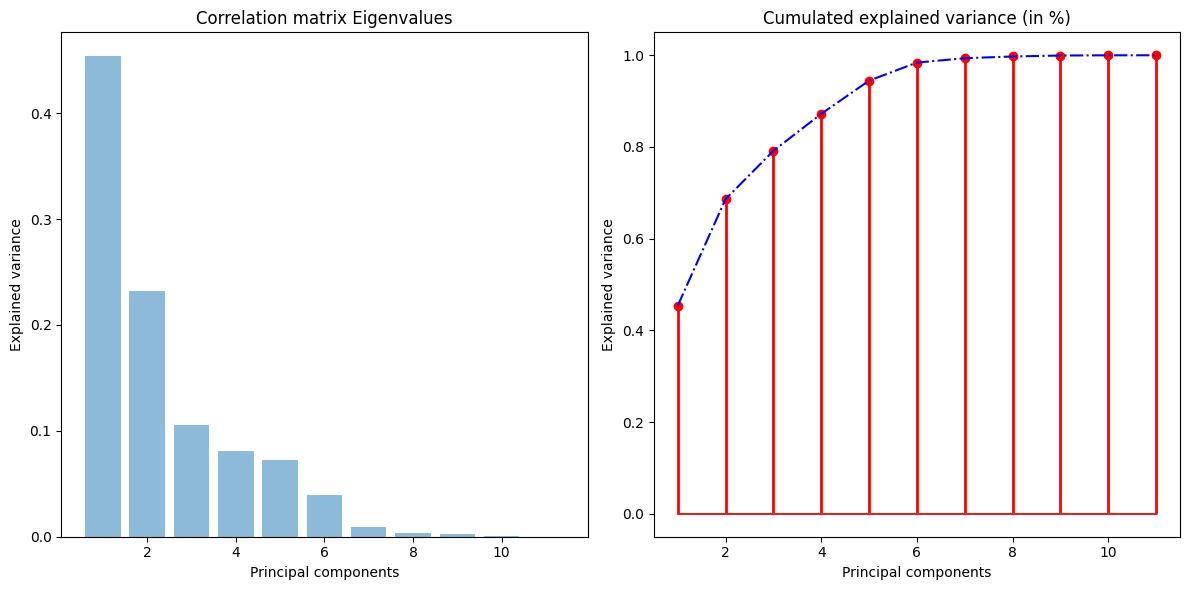

In [92]:
# Plot the spectrum
plot_spectre_variance_expl(pca.explained_variance_ratio_)

Le diagramme en barres (à gauche) montre la variance expliquée par chaque composante principale individuellement. Le graphe en tiges (à droite) montre la variance cumulée expliquée au fur et à mesure des composantes principales. Ces graphiques permettent de décider combien de composantes on va conserver pour réduire la dimension, tout en gardant l'essentiel de l'information. Pour cela, on se fixe un seuil à 80%, 90% ou 95%, selon ce qu'on souhaite.
80%: on garde l'essentiel de l'information tout en réduisant la dimension de manière raisonnable
90%: on conserve presque toute la variance
95%: quasiment aucune perte d'information, mais moins de réduction de dimension.

Ilsemble qu'avec 6 composantes on explique quasiment l'ensemble de l'information, en tous cas un taux d'information suffisant. On est casiment à 100% d'information expliquée.

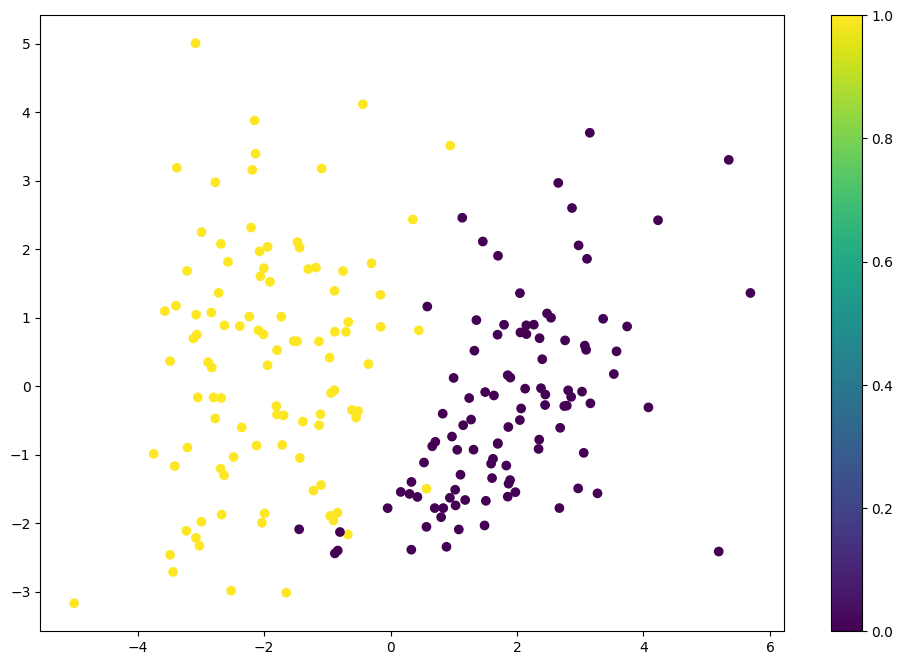

In [93]:
# le nombre de dimension souhaités après PCA
n_axes = 2
pca.n_components = n_axes
# transforme les donnes dans l'espace réduit (en 2D)
X_proj_ais = pca.transform(X_norm)

Y[Y=="f"] = 1
Y[Y=="m"] = 0

plt.figure(figsize=(12,8))
# c=Y: couleur des points selon le sexe
plt.scatter(X_proj_ais[:,0], X_proj_ais[:,1], c=Y)
plt.colorbar();

On a bien 2 clusters de données qui sont casiment parfaitement séparés.

In [109]:
# transforme les donnes dans l'espace réduit (en 2D)
X = df[variables].values
pca = PCA()
pca.fit(X)
X_proj_ais = pca.transform(X)

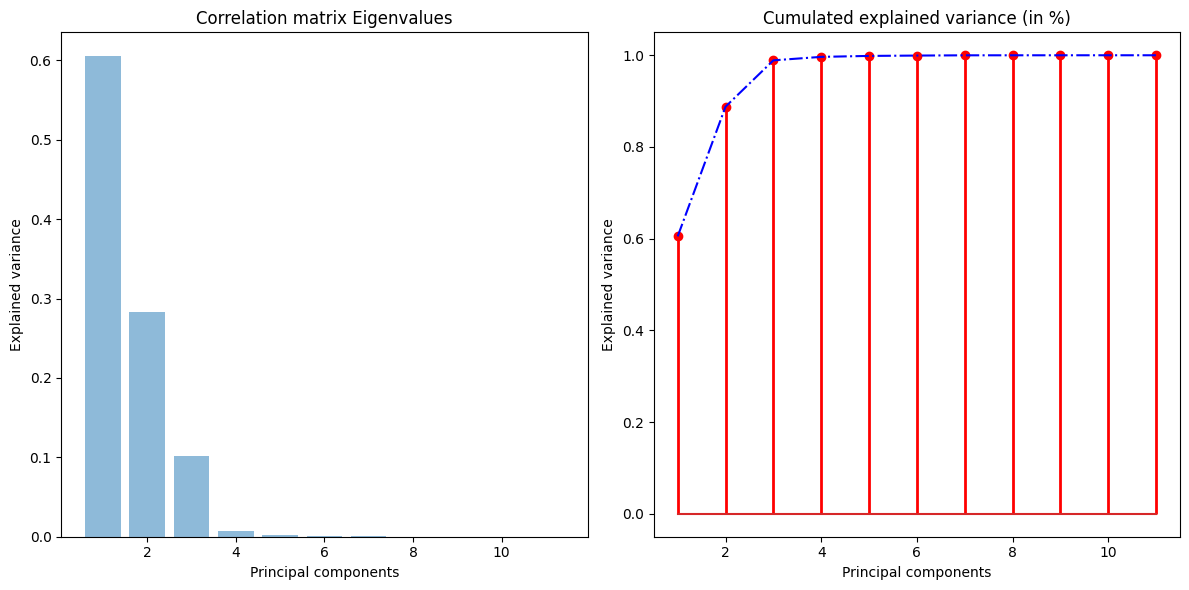

In [110]:
plot_spectre_variance_expl(pca.explained_variance_ratio_)

On constate en effet une différence, sans normalisation, les premières composantes capturent presque toute la variance car on a une domination des variables de grande échelle (c'est pour ça que sur le graphe en tiges (à droite) on obtient quasiment 100% de variance expliquée avec très peu de composantes alors qu'avec normalisation, la variance est répartie plus équitablement entre les composantes donc on a une meilleure représentation de toutes les variables (la normalisation corrige le biais d'influence des variables de grande échelle). En normalisant, on permet à la PCA de détecter les directions principales basées sur les relations entre variables, pas leur échelle.  
Conclusion: encore une fois, on le constate, il faut normaliser les données !

## Visualisation of digits

Dans cette partie, on s'interesse à l'étude de chiffres manuscrits allant de 0 à 9 tel que chaque chiffre est constitué d'une image en niveau de gris de taille 16*16. Les images sont stockées sous forme de vecteur dans la matrice X.  
L'objectif est double: visualiser les chiffres en 2D et expérimenter la reconstruction des chiffres après ACP, puisque l'ACP a pour objectif de pouvoir permettre la reconstruction puisque l'on fait en sorte de garder un maximum d'information.

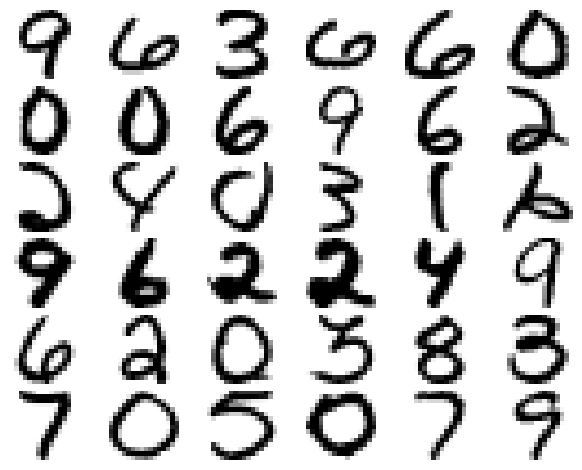

In [121]:
digits = sio.loadmat("uspsasi.mat")
digits, labels = digits["x"], digits["y"][:,0]

# digits["x"] contient les images de chiffres (les images vectorisées en dimension 256)
# digits["y"] contient les labels des chiffres (0 à 9)
# [:,0] transforme le tableau des labels en vecteur 1D.
fig, ax_array = plt.subplots(6,6)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits[i].reshape(16, 16), cmap="gray_r")
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

In [122]:
# nombre de lignes = nombre d'image
print(f"Nombre d'images: {digits.shape[0]}")      
# nombre de colonnes = dimension du vecteur 
print(f"Taille de chaque image (vecteur): {digits.shape[1]}")  

Nombre d'images: 2007
Taille de chaque image (vecteur): 256


In [123]:
sc = StandardScaler(with_mean=True, with_std=True)
X = digits  
X_n = sc.fit_transform(X) 
X = X_n

In [124]:
pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)

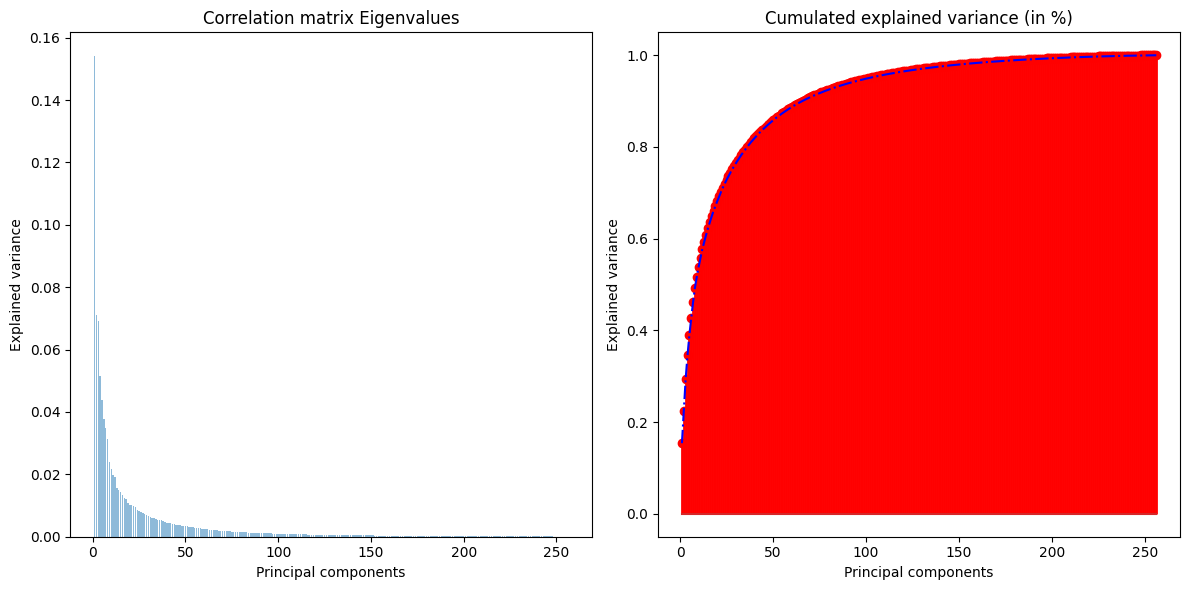

In [125]:
plot_spectre_variance_expl(pca.explained_variance_ratio_)

Désormais, on a plus 11 composantes mais 256 !  
Le seuil en pourcentage a 80, 90 ou 95% expliqué tout à l'heure trouve tout son intérêt maintenant !  
Pour un seuil à 95%, on conserve environ 120 composantes, pour un seuil à 90%, on conserve environ 75 composantes et pour un seuil à 80%, on conserve environ 40 composantes.

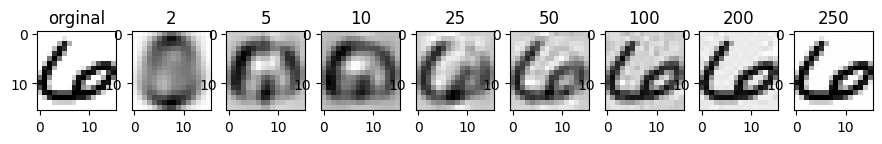

In [128]:
# on souhaite observer l'effet de la réduction de dimension sur la reconstruction
n_axes_vect = np.array([2, 5, 10, 25, 50, 100, 200, 250])
idx = 1
plt.figure(figsize=(12, 12))
plt.subplot(1, n_axes_vect.size+2, 1),
plt.imshow(digits[idx].reshape(16, 16), cmap="gray_r")
plt.title("orginal")
for idx_k, n_axes in enumerate(n_axes_vect):
    # fix the number of components
    pca_digit = PCA(n_components=n_axes)
    # fit the PCA model
    pca_digit.fit(digits)
    # projection
    Xproj = pca_digit.transform(digits)
    # reconstruction
    X_hat = pca_digit.inverse_transform(Xproj)
    plt.subplot(1, n_axes_vect.size+2, idx_k+2)
    plt.imshow(X_hat[idx].reshape(16, 16), cmap="gray_r")
    plt.title(n_axes)

Plus n_axes est grand et plus la reconstruction est fidèle à l'image originale, c'est logique, car on applique la PCA dans le but de réduire la dimension sans enlever trop de dimensions par rapport à si n_axes est petit.

A la reconstruction, on remarque en effet qu'en dessous de 50 composantes, l'image est encore flou, cela correspon d'ailleurs à 80% de l'information retenu. Donc un seuil à 95% est il semble nécessaire puisqu'à partir de 100 dimensions retenues, on distingue bien le digit, il n'est pas trop flou. Il semble que ce soit le meilleur compromis.

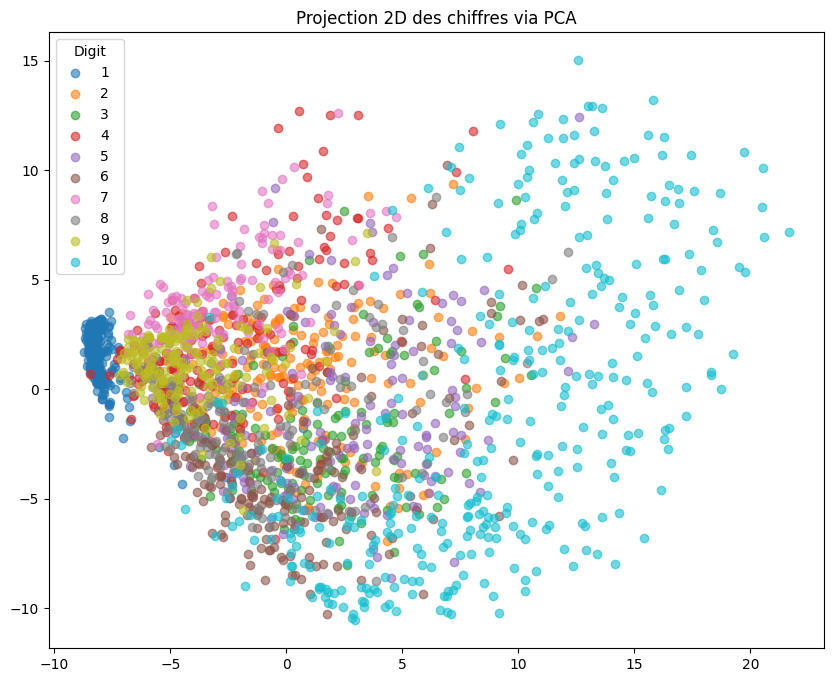

In [140]:
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(10,8))
for digit in np.unique(labels):
    # masque pour sélectionner tous les points de la classe idx
    idx = labels == digit
    plt.scatter(X_2d[idx,0], X_2d[idx,1], label=str(digit), alpha=0.6)

plt.title("Projection 2D des chiffres via PCA")
plt.legend(title="Digit")
plt.show()

Globalement, la PCA ne fournit pas une bonne séparation des classes, on ne voit pas les points séparés en clusters comme dans la méthode à suivre non-linaire t-SNE.

## A non-linear projection method: t-SNE

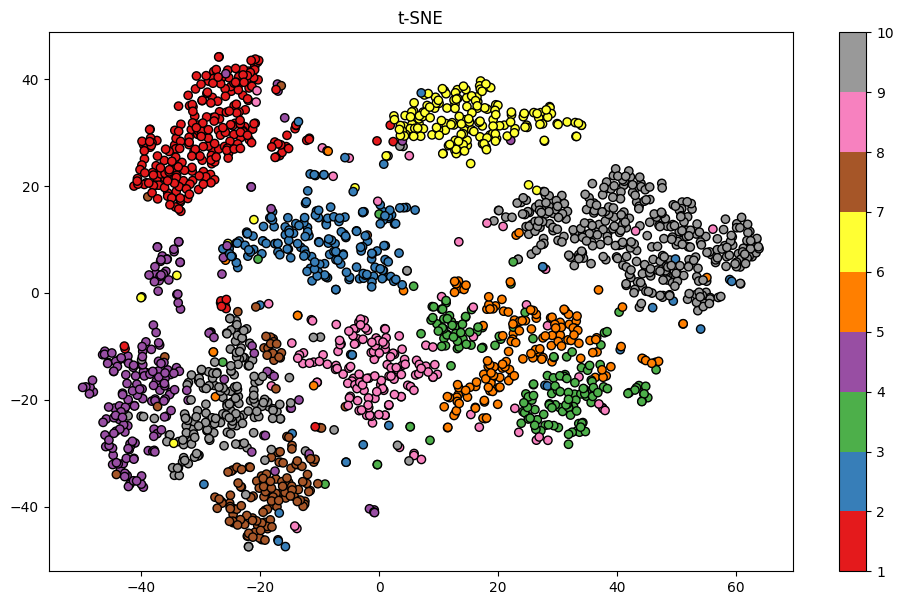

In [146]:
tsne_model = tsne(n_components=2)
X_proj_2d_tsne = tsne_model.fit_transform(digits)

plt.figure(figsize=(12, 7))
plt.scatter(X_proj_2d_tsne[:,0], X_proj_2d_tsne[:, 1], c=labels, 
            cmap=plt.cm.Set1, edgecolor="k")
plt.colorbar()
plt.title("t-SNE");

Chaque point correspond à une image projetée en 2D, les points proches les uns des autres correspondent à des images similaires donc les clusters représentent des groupes de chiffres. On a des légers chevauchement mais globalement on a tout de même 9 clusters bien distants.